In [1]:
import pandas as pd
import numpy as np
from custom_model import build_model, ResultsProcessor
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import seaborn as sn
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/transformed/final_dataframe.csv', index_col=0)

In [3]:
df[['home_team', 'visitor_team']] = df[['home_team', 'visitor_team']].astype('category')
df['home_team_cat'] = df['home_team'].cat.codes
df['visitor_team_cat'] = df['visitor_team'].cat.codes
df['home_final'] = df[[col for col in df.columns if 'H ' in col]].sum(axis=1)
df['visitor_final'] = df[[col for col in df.columns if 'V ' in col]].sum(axis=1)
scores = df[['home_final', 'visitor_final']].values.reshape(-1, 1)
score_scaler = StandardScaler().fit(scores)
scaled_scores = score_scaler.transform(scores).reshape(-1, 2)
df['home_final_scaled'] = scaled_scores[:, 0]
df['visitor_final_scaled'] = scaled_scores[:, 1]

In [4]:
df['final_spread'] = df['home_final'] - df['visitor_final']
df['final_total'] = df['home_final'] + df['visitor_final']
df['final_margin_from_open_spread'] = df['final_spread'] - (df['home_score_open'] - df['visitor_score_open'])
df['final_margin_from_open_total'] = df['final_total'] - (df['home_score_open'] + df['visitor_score_open'])

In [5]:
seq_len = 200
state_size = 8
l1 = l2 = 0.001
teams = len(df['visitor_team'].cat.categories)
line_used = 'open'

In [6]:
def map_to_cat(x, categories):
    if x == categories[0]:
        return 1
    elif x == categories[1]:
        return 0
    else:
        return 0.5

In [7]:
df['open_spread_win_cat'] = df['open_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['close_spread_win_cat'] = df['close_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['open_total_win_cat'] = df['open_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))
df['close_total_win_cat'] = df['close_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))

In [8]:
train = range(127, 6727)
test = range(6727, len(df)-1)

seq_start = [train[0] + len(train)%seq_len + seq_len*i for i in range(len(train)//seq_len)]
time_series_train = [range(start, start+seq_len) for start in seq_start]
time_series_plus_train = [range(start+1, start+1+seq_len) for start in seq_start]
seq_start_test = [test[0] + seq_len*i for i in range(len(test)//seq_len)]
time_series_test = [range(start, start+seq_len) for start in seq_start_test]
time_series_plus_test = [range(start+1, start+1+seq_len) for start in seq_start_test]

In [9]:
def convert_to_time_series(tensor, time_series_list):
    tensor_list = []
    for r in time_series_list:
        tensor_list += [tensor[r]]
    return np.stack(tensor_list)

In [10]:
cols = ['home_team_cat', 'visitor_team_cat']
teams_train = convert_to_time_series(
    df[cols].values, time_series_train).astype(np.int32)
teams_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train).astype(np.int32)
teams_test = convert_to_time_series(
    df[cols].values, time_series_test).astype(np.int32)
teams_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test).astype(np.int32)

In [11]:
cols = ['home_days_since_home', 'home_days_since_away', 'visitor_days_since_home', 'visitor_days_since_away']
days_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = days_scaled[:, i]

days_off_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
days_off_plus_train = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_train)
days_off_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)
days_off_plus_test = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_test)

In [12]:
cols = ['home_score_open', 'visitor_score_open', 'home_score_close', 'visitor_score_close']
lines_scaler = StandardScaler().fit(df[cols])
lines_scaled = lines_scaler.transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = lines_scaled[:, i]

lines_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
lines_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = [col for col in scaled_cols if line_used in col]
lines_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
lines_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

In [13]:
cols = ['H 1st', 'H 2nd', 'H 3rd', 'H 4th', 'V 1st', 'V 2nd', 'V 3rd', 'V 4th']
scores_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = scores_scaled[:, i]

scores_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
scores_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = ['home_final_scaled', 'visitor_final_scaled']
scores_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
scores_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

cols = ['open_spread_win_cat', 'open_total_win_cat', 'close_spread_win_cat', 'close_total_win_cat']
cols = [col for col in cols if line_used in col]
outcomes_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train) / 2 + 0.25
outcomes_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test) / 2 + 0.25

In [14]:
model = build_model(seq_len, state_size, teams, l1=l1, l2=l2)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(1, 200, 4)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(1, 200, 2)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(1, 200, 4)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, 200, 4)]        0                                            
_______________________________________________________________________________________

In [16]:
import copy

def shuffle_games(X, distance=10, fraction=0.25):
    reorder = np.random.choice(X[0].shape[1] - distance, 
                               size=(int(X[0].shape[1] * fraction)),
                               replace=False)
    targets = reorder + distance
    keep = np.array([k for k, r in enumerate(reorder) if r not in targets])
    reorder = reorder[keep]
    targets = targets[keep]

    X_out = []
    for tensor in X:
        tensor[:, np.append(targets, reorder)] = tensor[:, np.append(reorder, targets)]
        X_out += [tensor]
    
    return X_out

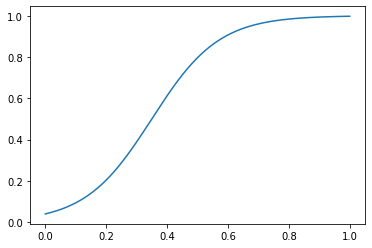

In [17]:
def sigmoid(x):
    return 1/(1+np.exp(-(x-0.35)/0.11))#1/(1+np.exp(-(x-0.1)/0.01))#1/(1+np.exp(-(x-0.35)/0.11))

x = np.linspace(0, 1, len(train))
sample_weights = np.expand_dims(sigmoid(x),axis=1)

sample_weights_final = [sample_weights.reshape(-1, seq_len), sample_weights.reshape(-1, seq_len)]

plt.plot(x, sample_weights)
plt.show()

In [20]:
opt = tf.keras.optimizers.Adam(lr=0.001)
negloglik = lambda y, p_y: -p_y.log_prob(y)
model.compile(
    optimizer=opt, loss=negloglik
)
epochs = 60

In [21]:
X = [np.expand_dims(teams_train, axis=-1), days_off_train, lines_train, scores_train, 
     np.expand_dims(teams_plus_train, axis=-1), days_off_plus_train, lines_plus_train, scores_plus_train]

for i in range(epochs):
    print('Epoch {}'.format(str(i+1)))
    model.reset_states()
    # X = shuffle_games(copy.deepcopy(X))
    model.fit(
        x=X[:7],
        y=X[7:],
        batch_size=1,
        epochs=1,
        sample_weight=sample_weights_final,
        verbose=1
    )

Epoch 1
33/33 [==============================] - 2s 52ms/step - loss: 4.1444
Epoch 2
33/33 [==============================] - 2s 51ms/step - loss: 3.1359
Epoch 3
33/33 [==============================] - 1s 45ms/step - loss: 2.8302
Epoch 4
33/33 [==============================] - 1s 37ms/step - loss: 2.7312
Epoch 5
33/33 [==============================] - 1s 37ms/step - loss: 2.6525
Epoch 6
33/33 [==============================] - 1s 37ms/step - loss: 2.5887
Epoch 7
33/33 [==============================] - 1s 36ms/step - loss: 2.5702
Epoch 8
33/33 [==============================] - 1s 36ms/step - loss: 2.5173
Epoch 9
33/33 [==============================] - 1s 36ms/step - loss: 2.5256
Epoch 10
33/33 [==============================] - 1s 37ms/step - loss: 2.4861
Epoch 11
33/33 [==============================] - 1s 39ms/step - loss: 2.4510
Epoch 12
33/33 [==============================] - 1s 38ms/step - loss: 2.4080
Epoch 13
33/33 [==============================] - 1s 39ms/step - loss: 2.

In [22]:
rnn_layer = model.layers[9]
rnn_layer

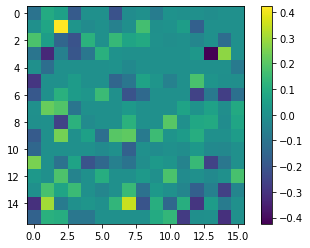

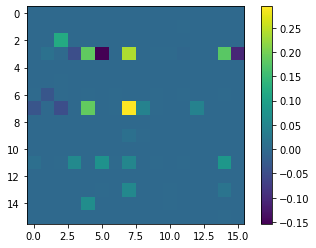

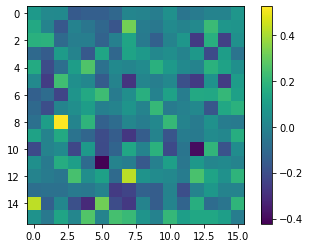

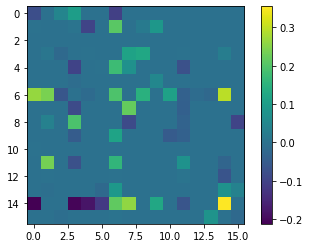

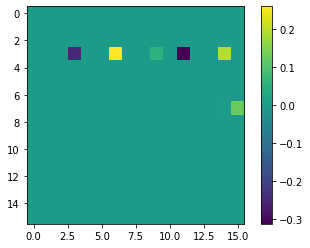

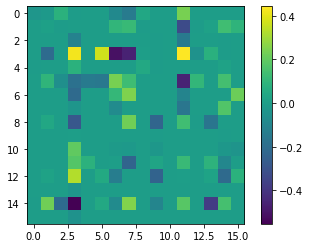

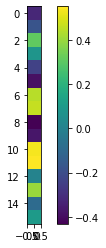

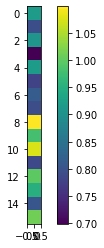

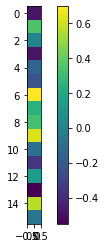

In [23]:
for weight in rnn_layer.get_weights():
    plt.imshow(weight)
    plt.colorbar()
    plt.show()

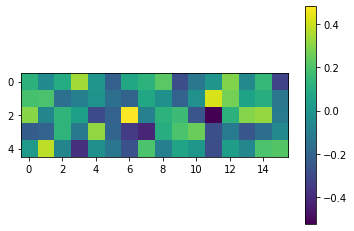

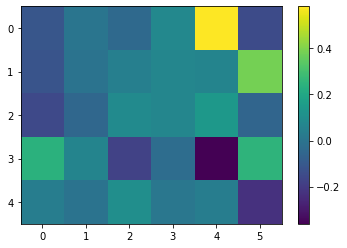

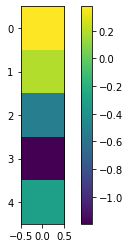

In [24]:
for weight in model.layers[-3].get_weights():
    plt.imshow(weight)
    plt.colorbar()
    plt.show()

In [25]:
df_states = pd.DataFrame(rnn_layer.states[0][0].numpy().T, columns=list(df['home_team'].cat.categories))

<AxesSubplot:>

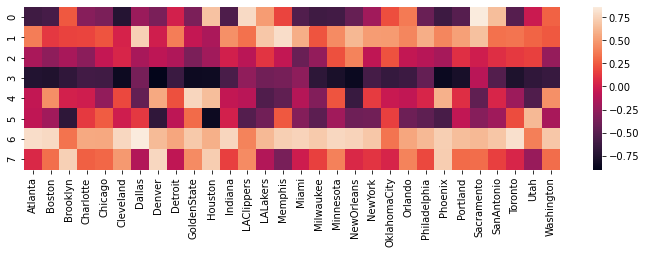

In [26]:
plt.rcParams['figure.figsize'] = 12, 3
sn.heatmap(df_states)

In [27]:
import copy
states = copy.deepcopy(rnn_layer.states)

In [28]:
rnn_layer.reset_states(states[0].numpy())

In [29]:
result = ResultsProcessor(score_scaler, min_score=60, max_score=160)

In [30]:
if line_used == 'open':
    cols = np.array([0, 1])
else:
    cols = np.array([2, 3])

In [31]:
mvns = []
spread_preds = np.array([])
total_preds = np.array([])
for batch in range(teams_test.shape[0]):
    score_preds_ = model(
        [np.expand_dims(teams_test, axis=-1)[batch: batch+1], 
        days_off_test[batch: batch+1], 
        lines_test[batch: batch+1], scores_test[batch: batch+1], 
        np.expand_dims(teams_plus_test, axis=-1)[batch: batch+1], 
        days_off_plus_test[batch: batch+1], lines_plus_test[batch: batch+1]])
    print(rnn_layer.states[0].numpy()[0, 10])
    mvns += result.make_mvn_from_batch(score_preds_)
    lines = lines_plus_test[batch] * lines_scaler.scale_[cols] + lines_scaler.mean_[cols]
    spreads = lines[:, 0] - lines[:, 1]
    totals = lines[:, 0] + lines[:, 1]
    spread_like, total_like = result.get_spread_total_likelihood(
        mvns[-seq_len:], spreads, totals)
    spread_preds = np.append(spread_preds, spread_like)
    total_preds = np.append(total_preds, total_like)

[ 0.24340779 -0.25394583 -0.32565677 -0.8781712   0.62480336 -0.6622325
  0.73638535  0.76842904]
[-0.22417647 -0.01364905 -0.3413865  -0.8927959   0.7758561  -0.78606665
  0.72268754  0.84804946]
[-0.8939916   0.24941799 -0.2085348  -0.8899628   0.58272004 -0.7677966
  0.9187816   0.52739835]


In [32]:
mvns_train = []
spread_preds_train = np.array([])
total_preds_train = np.array([])
rnn_layer.reset_states(np.zeros(states[0].numpy().shape))
for batch in range(teams_train.shape[0]):
    score_preds_ = model(
        [np.expand_dims(teams_train, axis=-1)[batch: batch+1], 
            days_off_train[batch: batch+1], 
            lines_train[batch: batch+1], scores_train[batch: batch+1], 
            np.expand_dims(teams_plus_train, axis=-1)[batch: batch+1], 
            days_off_plus_train[batch: batch+1], lines_plus_train[batch: batch+1]])
    print(rnn_layer.states[0].numpy()[0, 10])
    mvns_train += result.make_mvn_from_batch(score_preds_)
    lines = lines_plus_train[batch] * lines_scaler.scale_[cols] + lines_scaler.mean_[cols]
    spreads = lines[:, 0] - lines[:, 1]
    totals = lines[:, 0] + lines[:, 1]
    spread_like, total_like = result.get_spread_total_likelihood(
        mvns_train[-seq_len:], spreads, totals)
    spread_preds_train = np.append(spread_preds_train, spread_like)
    total_preds_train = np.append(total_preds_train, total_like)

[ 0.18393649  0.4195832  -0.13681944 -0.5479164   0.06623064 -0.24710867
  0.46874166  0.30747807]
[-0.04337472  0.57296395 -0.10760657 -0.492551   -0.11361598  0.14768107
  0.7733945  -0.06902906]
[-0.58148766  0.40587837  0.05966727 -0.7653044   0.15574934 -0.19115606
  0.6684121   0.04721752]
[-5.0329757e-01  3.4382182e-01 -3.4864247e-04 -6.2048876e-01
 -2.4148646e-01 -9.1369510e-02  7.7052200e-01 -9.1295242e-02]
[-0.19405004  0.64672494  0.06826822 -0.5790139   0.08805466  0.2780597
  0.6539144  -0.39440483]
[-0.26810837  0.7271602  -0.09440431 -0.3922332  -0.24329877  0.25717068
  0.6263739  -0.61921626]
[-0.01879752  0.65550447 -0.10294133 -0.25619018 -0.30750948 -0.02662849
  0.63549316 -0.05244893]
[ 0.3675246   0.09546687 -0.30067235 -0.68765724  0.2313555  -0.4296983
  0.52363497  0.5067952 ]
[-0.58286715  0.24526629 -0.14270943 -0.6513958  -0.2811817   0.26177052
  0.5007348   0.30287245]
[-0.22888918  0.7357738  -0.08992282 -0.442299   -0.33152324 -0.07929371
  0.82995105 -

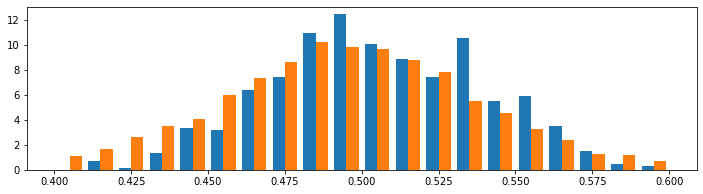

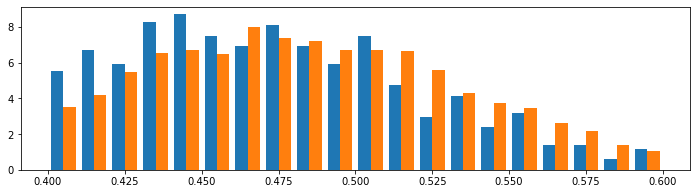

In [33]:
bins = np.linspace(0.4, 0.6, 21)
plt.hist([spread_preds, spread_preds_train], density=True, bins=bins)
plt.show()

plt.hist([total_preds, total_preds_train], density=True, bins=bins)
plt.show()

In [38]:
spread_preds_scaled = (spread_preds - 0.5) / 2 + 0.5
total_preds_scaled = (total_preds - 0.5) / 2 + 0.5

In [38]:
bank = 1000
bank_history = [bank]
bet_cost = 110
betting_spreads = True
betting_totals = False
b = 100 / bet_cost
kelly_frac = 0.5
for i, game in enumerate(test):
    if betting_spreads:
        bet_frac_home = (spread_preds[i] * (1 + b) - 1) / b
        bet_frac_visitor = ((1-spread_preds[i]) * (1 + b) - 1) / b
        if bet_frac_home > 0:
            bet_spread = ('home', kelly_frac * bet_frac_home * bank)
        elif bet_frac_visitor > 0:
            bet_spread = ('visitor', kelly_frac * bet_frac_visitor * bank)
        else:
            bet_spread = ('neither', 0)
    else:
        bet_spread = ('neither', 0)

    bank -= bet_spread[1]

    if betting_totals:
        bet_frac_over = (total_preds[i] * (1 + b) - 1) / b
        bet_frac_under = ((1-total_preds[i]) * (1 + b) - 1) / b
        if bet_frac_over > 0:
            bet_total = ('over', kelly_frac * bet_frac_over * bank)
        elif bet_frac_under > 0:
            bet_total = ('under', kelly_frac * bet_frac_under * bank)
        else:
            bet_total = ('neither', 0)
    else:
        bet_total = ('neither', 0)

    bank -= bet_total[1]

    score = df.iloc[game + 1][['home_final', 'visitor_final']].values
    lines = df.iloc[game + 1][['home_score_open', 'visitor_score_open']].values
    spread = lines[0] - lines[1]
    total = lines[0] + lines[1]
    actual_spread = score[0] - score[1]
    actual_total = score[0] + score[1]
    if actual_spread - spread > 0:
        spread_win = 'home'
    elif actual_spread - spread < 0:
        spread_win = 'visitor'
    else:
        spread_win = 'neither'
        
    if actual_total - total > 0:
        total_win = 'home'
    elif actual_total - total < 0:
        total_win = 'under'
    else:
        total_win = 'neither'

    if bet_spread[0] == spread_win:
        bank += bet_spread[1] * (1 + b)
    elif spread_win == 'neither':
        bank += bet_spread[1]

    if bet_total[0] == total_win:
        bank += bet_total[1] * (1 + b)
    elif total_win == 'neither':
        bank += bet_total[1]

    bank_history += [bank]

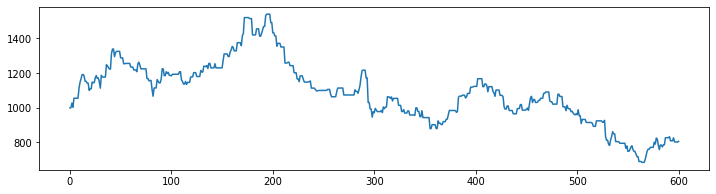

In [39]:
plt.plot(bank_history)

In [42]:
bank = 1000
bank_history_train = [bank]
bet_cost = 110
betting_spreads = True
betting_totals = False
b = 100 / bet_cost
kelly_frac = 0.5
for i, game in enumerate(train):
    if i < 50:
        continue
    if betting_spreads:
        bet_frac_home = (spread_preds_train[i] * (1 + b) - 1) / b
        bet_frac_visitor = ((1-spread_preds_train[i]) * (1 + b) - 1) / b
        if bet_frac_home > 0:
            bet_spread = ('home', kelly_frac * bet_frac_home * bank)
        elif bet_frac_visitor > 0:
            bet_spread = ('visitor', kelly_frac * bet_frac_visitor * bank)
        else:
            bet_spread = ('neither', 0)
    else:
        bet_spread = ('neither', 0)

    bank -= bet_spread[1]

    if betting_totals:
        bet_frac_over = (total_preds_train[i] * (1 + b) - 1) / b
        bet_frac_under = ((1-total_preds_train[i]) * (1 + b) - 1) / b
        if bet_frac_over > 0:
            bet_total = ('over', kelly_frac * bet_frac_over * bank)
        elif bet_frac_under > 0:
            bet_total = ('under', kelly_frac * bet_frac_under * bank)
        else:
            bet_total = ('neither', 0)
    else:
        bet_total = ('neither', 0)

    bank -= bet_total[1]

    score = df.iloc[game + 1][['home_final', 'visitor_final']].values
    lines = df.iloc[game + 1][['home_score_open', 'visitor_score_open']].values
    spread = lines[0] - lines[1]
    total = lines[0] + lines[1]
    actual_spread = score[0] - score[1]
    actual_total = score[0] + score[1]
    if actual_spread - spread > 0:
        spread_win = 'home'
    elif actual_spread - spread < 0:
        spread_win = 'visitor'
    else:
        spread_win = 'neither'
        
    if actual_total - total > 0:
        total_win = 'home'
    elif actual_total - total < 0:
        total_win = 'under'
    else:
        total_win = 'neither'

    if bet_spread[0] == spread_win:
        bank += bet_spread[1] * (1 + b)
    elif spread_win == 'neither':
        bank += bet_spread[1]

    if bet_total[0] == total_win:
        bank += bet_total[1] * (1 + b)
    elif total_win == 'neither':
        bank += bet_total[1]

    bank_history_train += [bank]

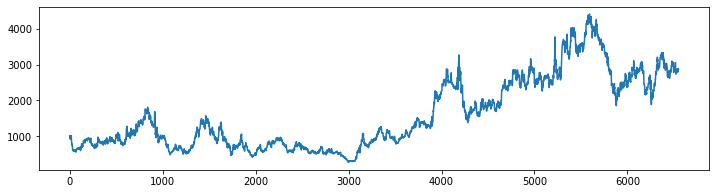

In [43]:
plt.plot(bank_history_train)

In [44]:
means = []
for mvn in mvns:
    means += [mvn.mean]

score_preds = score_scaler.inverse_transform(
    np.array(means).reshape(-1, 1)).reshape(-1, 2)

means = []
for mvn in mvns_train:
    means += [mvn.mean]

score_preds_train = score_scaler.inverse_transform(
    np.array(means).reshape(-1, 1)).reshape(-1, 2)

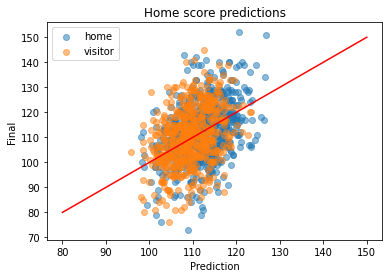

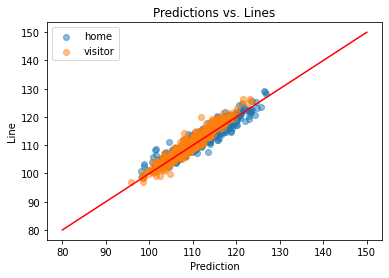

In [45]:
plt.rcParams['figure.figsize'] = 6, 4

plt.scatter(score_preds[:, 0], df['home_final'][-len(test):], alpha=0.5, label='home')
plt.scatter(score_preds[:, 1], df['visitor_final'][-len(test):], alpha=0.5, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Final')
plt.title('Home score predictions')
plt.show()

plt.scatter(score_preds[:, 0], df['home_score_open'][-len(test):], alpha=0.5, label='home')
plt.scatter(score_preds[:, 1], df['visitor_score_open'][-len(test):], alpha=0.5, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Line')
plt.title('Predictions vs. Lines')
plt.show()


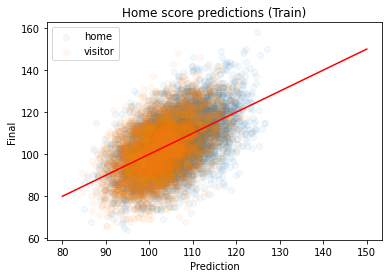

In [46]:
plt.scatter(score_preds_train[:, 0], df['home_final'][128:-len(test)], alpha=0.05, label='home')
plt.scatter(score_preds_train[:, 1], df['visitor_final'][128:-len(test)], alpha=0.05, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Final')
plt.title('Home score predictions (Train)')
plt.show()

In [47]:
home_error = mean_absolute_error(df['home_final'][-len(test):], score_preds[:, 0])
visitor_error = mean_absolute_error(df['visitor_final'][-len(test):], score_preds[:, 1])
home_line_error = mean_absolute_error(df['home_final'][-len(test):], df['home_score_open'][-len(test):])
visitor_line_error = mean_absolute_error(df['visitor_final'][-len(test):], df['visitor_score_open'][-len(test):])
print(home_error)
print(visitor_error)
print(home_line_error)
print(visitor_line_error)

8.784799160513405
8.564133304605543
8.69125
8.56125


In [48]:
home_error_train = mean_absolute_error(df['home_final'][128:-len(test)], score_preds_train[:, 0])
visitor_error_train = mean_absolute_error(df['visitor_final'][128:-len(test)], score_preds_train[:, 1])
home_line_error_train = mean_absolute_error(df['home_final'][128:-len(test)], df['home_score_open'][128:-len(test)])
visitor_line_error_train = mean_absolute_error(df['visitor_final'][128:-len(test):], df['visitor_score_open'][128:-len(test)])
print(home_error_train)
print(visitor_error_train)
print(home_line_error_train)
print(visitor_line_error_train)

8.298321819099518
8.361843214706205
8.29465821969697
8.351099356060606


In [49]:
print(np.corrcoef(spread_preds, df['final_margin_from_open_spread'][-len(test):])[0, 1])
print(np.corrcoef(spread_preds, np.sign(df['final_margin_from_open_spread'][-len(test):]))[0, 1])
print(np.corrcoef(total_preds, df['final_margin_from_open_total'][-len(test):])[0, 1])
print(np.corrcoef(total_preds, np.sign(df['final_margin_from_open_total'][-len(test):]))[0, 1])

0.022697761156637457
0.01973698636263838
0.0898802528280695
0.029765753401366796


In [50]:
print(np.corrcoef(spread_preds_train, df['final_margin_from_open_spread'][128:-len(test)])[0, 1])
print(np.corrcoef(spread_preds_train, np.sign(df['final_margin_from_open_spread'][128:-len(test)]))[0, 1])
print(np.corrcoef(total_preds_train, df['final_margin_from_open_total'][128:-len(test)])[0, 1])
print(np.corrcoef(total_preds_train, np.sign(df['final_margin_from_open_total'][128:-len(test)]))[0, 1])

0.06329053597504056
0.043904879768727686
0.0594255328996279
0.050939004848935474


In [51]:
spread_model = LinearRegression()
total_model = LinearRegression()
spread_model.fit(spread_preds.reshape(-1, 1), df['final_margin_from_open_spread'][-len(test):])
total_model.fit(total_preds.reshape(-1, 1), df['final_margin_from_open_total'][-len(test):])

LinearRegression()

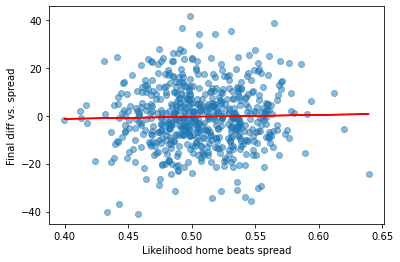

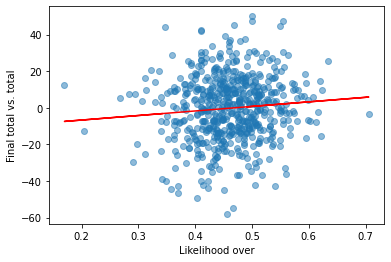

In [52]:
plt.scatter(spread_preds, df['final_margin_from_open_spread'][-len(test):], alpha=0.5)
plt.plot(spread_preds, spread_model.predict(spread_preds.reshape(-1, 1)), c='red')
plt.xlabel('Likelihood home beats spread')
plt.ylabel('Final diff vs. spread')
plt.show()

plt.scatter(total_preds, df['final_margin_from_open_total'][-len(test):], alpha=0.5)
plt.plot(total_preds, total_model.predict(total_preds.reshape(-1, 1)), c='red')
plt.xlabel('Likelihood over')
plt.ylabel('Final total vs. total')
plt.show()

In [53]:
spread_wins = len(np.where((spread_preds > 0.5) & (df['final_margin_from_open_spread'][-len(test):] > 0))[0])
spread_wins += len(np.where((spread_preds < 0.5) & (df['final_margin_from_open_spread'][-len(test):] < 0))[0])
den = len(test) - len(np.where(df['final_margin_from_open_spread'][-len(test):] == 0)[0])
win_fraction = spread_wins / den
win_fraction

0.4906937394247039

In [54]:
total_wins = len(np.where((total_preds > 0.5) & (df['final_margin_from_open_total'][-len(test):] > 0))[0])
total_wins += len(np.where((total_preds < 0.5) & (df['final_margin_from_open_total'][-len(test):] < 0))[0])
den = len(test) - len(np.where(df['final_margin_from_open_total'][-len(test):] == 0)[0])
win_fraction = total_wins / den
win_fraction

0.507537688442211

In [55]:
spread_wins_train = len(np.where((spread_preds_train > 0.5) & (df['final_margin_from_open_spread'][128:-len(test)] > 0))[0])
spread_wins_train += len(np.where((spread_preds_train < 0.5) & (df['final_margin_from_open_spread'][128:-len(test)] < 0))[0])
den = 6600 - len(np.where(df['final_margin_from_open_spread'][128:-len(test)] == 0)[0])
win_fraction = spread_wins_train / den
win_fraction

0.5153061224489796

In [56]:
total_wins_train = len(np.where((total_preds_train > 0.5) & (df['final_margin_from_open_total'][128:-len(test)] > 0))[0])
total_wins_train += len(np.where((total_preds_train < 0.5) & (df['final_margin_from_open_total'][128:-len(test)] < 0))[0])
den = 6600 - len(np.where(df['final_margin_from_open_spread'][128:-len(test)] == 0)[0])
win_fraction = total_wins_train / den
win_fraction

0.5367965367965368